# Experiment and path specification

In [ ]:
# Specify the experiment for analysis
experiment='cxilu9218'
runNumber = 21

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [24]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
print os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic'
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic
igabalsk



# Leveraging the batch queue to quickly grab detector data

## Loading libraries

In [25]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsLibraries')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

## Load point data

In [26]:
pointData = load_obj( os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )

/cds/data/psdm/cxi/cxilu9218/results/igabalsk/pointData-run-20 remembered!


## Plot histogram of result

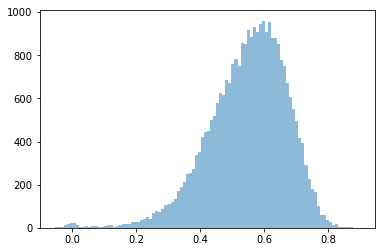

In [27]:
detArrays = pointData

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['xrayEnergy'], bins=100,normed=False, alpha=0.5);

# Read in CSPAD via batch job

## Specify good idxs

In [28]:
goodIdx = runFilter( pointData , filterOn=['xrayEnergy', 'ttfltpos'], maddevs=3 ).astype(bool)
print 'Number of good shots: ', len(goodIdx[goodIdx==True])

Number of good shots:  19804


## Now generate time delays

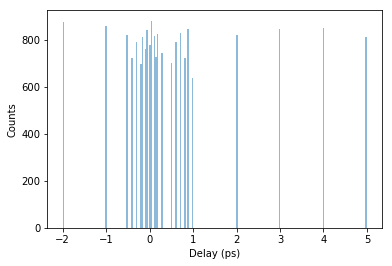

In [33]:
TTPoly = np.array([2.235e-7, -2.21e-3, 8.547e-1]) 

TTFltPos = pointData['ttfltpos']
TTCorrFltPos = TTPoly[0]*TTFltPos**2+TTPoly[1]*TTFltPos+TTPoly[2]
TTTime = 0*TTCorrFltPos - 1e9/3e8*2*(pointData['stageencoder']-56.35)

# NOTE: This is a placeholder, and should be removed on runs with timetool data
# TTTime = np.zeros(pointData['xrayEnergy'].shape)

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(TTTime[goodIdx], bins=200,normed=False, alpha=0.5)
ax2.set_xlabel('Delay (ps)')
ax2.set_ylabel('Counts')
plt.show()

# Read in all images
## If you just want to look at all the images at once

In [30]:
# tagList = []
# size_slice = len(goodIdx[goodIdx==True])
# for idx in range(1):
#     filteredSeconds = pointData['seconds'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     filteredNanoseconds = pointData['nanoseconds'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     filteredFiducials = pointData['fiducials'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# # batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
# batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
# timebins=np.arange(10)
# batchThreads.Queue = 'psfehhiprioq'   
# batchThreads.start()

In [35]:
print np.unique(TTTime)
print np.unique(pointData['stageencoder'])

[-2.00333333e+00 -2.00000000e+00 -1.30000000e+00 -1.00333333e+00
 -1.00000000e+00 -5.00000000e-01 -4.00000000e-01 -3.96666667e-01
 -3.03333333e-01 -3.00000000e-01 -2.00000000e-01 -1.53333333e-01
 -1.50000000e-01 -1.03333333e-01 -1.00000000e-01 -5.00000000e-02
 -0.00000000e+00  3.33333333e-03  5.00000000e-02  1.00000000e-01
  1.50000000e-01  1.53333333e-01  2.00000000e-01  2.03333333e-01
  3.00000000e-01  4.96666667e-01  5.00000000e-01  6.00000000e-01
  6.03333333e-01  6.83333333e-01  6.96666667e-01  7.00000000e-01
  7.76666667e-01  8.00000000e-01  8.06666667e-01  9.00000000e-01
  1.00000000e+00  1.00333333e+00  1.63666667e+00  1.96666667e+00
  2.00000000e+00  2.82666667e+00  2.99666667e+00  3.69000000e+00
  3.99666667e+00  4.00000000e+00  4.99666667e+00  5.00000000e+00]
[55.6    55.6005 55.75   55.7505 55.7965 55.9005 55.926  56.05   56.055
 56.1045 56.1995 56.2    56.215  56.229  56.23   56.2335 56.245  56.2455
 56.2475 56.2595 56.26   56.275  56.2755 56.305  56.3195 56.32   56.327
 5

# Read in timebinned CSPAD
## If you want to timebin your images

In [37]:
# timebins = np.arange( -1.5,1.5,.03 )
# timebins are in picoseconds
# timebins = np.arange( 2.,5.5,.03 ) 
# timebins = np.arange( -1, 1, .1 )
# timebins = np.array([-1.25,0.75])
timebins = np.unique(TTTime)
print 'Number of timebins: ', len(timebins)
dt = timebins[1]-timebins[0]
# dt = 0.75
NT = timebins.size

tagList = []
for idx, t in enumerate(timebins):
    tIndex = (TTTime >= t-dt/2.)&(TTTime < t+dt/2.)
    allIndex = tIndex & goodIdx
    filteredSeconds = pointData['seconds'][allIndex]
    filteredNanoseconds = pointData['nanoseconds'][allIndex]
    filteredFiducials = pointData['fiducials'][allIndex]
    tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')

batchThreads.Queue = 'psfehhiprioq'
batchThreads.RunType = 'mpirun python2'
batchThreads.start()


Number of timebins:  48
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-0.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-20-temp-CSPAD-0.py; exit'
Output: Job <291359> is submitted to queue <psfehhiprioq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-1.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-20-tem

Output: Job <291502> is submitted to queue <psfehhiprioq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-16.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-20-temp-CSPAD-16.py; exit'
Output: Job <291513> is submitted to queue <psfehhiprioq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-17.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/s

Output: Job <291669> is submitted to queue <psfehhiprioq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-32.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-20-temp-CSPAD-32.py; exit'
Output: Job <291681> is submitted to queue <psfehhiprioq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-33.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/s

Exception in thread Thread-77:
Traceback (most recent call last):
  File "/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 281, in run
    OutputName=self.OutputName)
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 221, in SubmitBatchJob
    return extractJobId( str(output) )
  File "/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/pythonBatchMagic.py", line 104, in extractJobId
    return m.group(0)[1:-1]
AttributeError: 'NoneType' object has no attribute 'group'



Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-46.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-20-temp-CSPAD-46.py; exit'
Output: Job <291834> is submitted to queue <psfehhiprioq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psfehhiprioq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-20-temp-CSPAD-47.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-20-temp-CSPAD-47.py; exit'


## Check job status

In [32]:
print batchThreads.status
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata

Finished
JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
284685  igabals RUN   psfehhipri psanagpu101 psana1601   *SPAD-3.py Nov 27 13:16
284694  igabals RUN   psfehhipri psanagpu101 psana1605   *SPAD-4.py Nov 27 13:16
284703  igabals RUN   psfehhipri psanagpu101 psana1609   *SPAD-5.py Nov 27 13:16
284712  igabals RUN   psfehhipri psanagpu101 psana1610   *SPAD-6.py Nov 27 13:16
284719  igabals RUN   psfehhipri psanagpu101 psana1603   *SPAD-7.py Nov 27 13:16
284725  igabals RUN   psfehhipri psanagpu101 psana1611   *SPAD-8.py Nov 27 13:16
284733  igabals RUN   psfehhipri psanagpu101 psana1607   *SPAD-9.py Nov 27 13:16
284741  igabals RUN   psfehhipri psanagpu101 psana1604   *PAD-10.py Nov 27 13:16
284752  igabals RUN   psfehhipri psanagpu101 psana1601   *PAD-11.py Nov 27 13:16
284763  igabals RUN   psfehhipri psanagpu101 psana1609   *PAD-12.py Nov 27 13:16
284772  igabals RUN   psfehhipri psanagpu101 psana1605   *PAD-13.py Nov 27 13:17
284790  igabals RUN 

## Kill threads if they die

In [36]:
batchThreads.requestStop()
time.sleep(5)
stdoutdata, stderrdata = bkill(killAll=True)
print stdoutdata
print stderrdata

Job <284712> is being terminated
Job <284719> is being terminated
Job <284725> is being terminated
Job <284733> is being terminated
Job <284741> is being terminated
Job <284804> is being terminated




# Save resulting CSPAD

In [38]:
batchThreads.gather()
CSPAD = batchThreads.CSPAD
variance = batchThreads.variance
counts = batchThreads.counts

/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-0-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-1-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-2-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-3-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-4-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-5-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-6-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-7-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-8-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/mean-var-node-9-run-20 remembered!
/cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/m

In [39]:
from scipy.io import savemat
np.save(os.environ['RESULTSPATH']+'/timebins-run-%d' % runNumber ,timebins)
np.save(os.environ['RESULTSPATH']+'/CSPAD-run-%d' % runNumber  , CSPAD)
np.save(os.environ['RESULTSPATH']+'/variance-run-%d' %  runNumber , variance)
np.save(os.environ['RESULTSPATH']+'/counts-run-%d' % runNumber  , counts)

filename = os.environ['RESULTSPATH']+'/timebinned-detector-images-run-%d' % runNumber
mdict = {'timebins':timebins,'CSPAD':CSPAD,'variance':variance,'counts':counts}
savemat(filename, mdict)

# Plot CSPAD

In [40]:
# # Optional code if timebinned frames are already saved
timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)

In [41]:
for i in range(CSPAD.shape[-1]):
    m = np.mean(CSPAD[:,:,:,i])
    if not np.isnan(m):
        print i, np.mean(CSPAD[:,:,:,i]), counts[i][0], timebins[i]

0 0.25648586224512365 6.0 -2.0033333333333303
1 0.14502140007237013 868.0 -1.9999999999999811
3 -0.11507290889373221 6.0 -1.0033333333333398
4 -0.2502110809761383 851.0 -0.9999999999999906
5 0.2523850824059575 819.0 -0.4999999999999716
6 -0.19792702231153067 724.0 -0.3999999999999678
8 -0.4556956971085001 14.0 -0.30333333333331325
9 -0.1601759671175011 776.0 -0.30000000000001137
10 -0.013806863263258301 698.0 -0.2000000000000076
11 0.07571249153988902 4.0 -0.15333333333330756
12 -0.10639993521660512 809.0 -0.15000000000000568
13 -0.05000096820835252 14.0 -0.10333333333330567
14 -0.15198703506256434 746.0 -0.1000000000000038
15 0.02941378269859869 842.0 -0.0500000000000019
16 -0.11508965983298594 774.0 -0.0
18 -0.1589914422528864 881.0 0.0500000000000019
19 -0.257752153651524 816.0 0.1000000000000038
20 -0.18013642728940382 728.0 0.15000000000000568
22 -0.22099254988851447 823.0 0.2000000000000076
23 -1.1381644711218541 1.0 0.20333333333335685
24 -0.14469283079883072 744.0 0.30000000000

In [ ]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False, NTILE=8 ):
    figOpts = {'xLims':[-1e5,1e5],'yLims':[-1e5,1e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(NTILE):
    
        if cspadMask is not None:
            cspadTile = cspad[iTile,:,:]
            tileMask = ~cspadMask[iTile,:,:]
            cspadTile[tileMask] = 0
        
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
            
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspadTile , newFigure=newFigure, **figOpts);


x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)
# cspadMask = createMask(experiment=experiment, run=runNumber, detType='Jungfrau').astype(bool)
cspadMask = np.ones_like(x).astype(bool)
print(cspadMask.shape)

print CSPAD.shape
CSPADbinned = CSPAD

# CSPADbinned[CSPADbinned>10]=0
CSPAD2plot = np.nansum(CSPADbinned[:,:,:,:],axis=-1)#-CSPADbinned[:,:,:,53]
# plotCSPAD( cspadMask, x , y , cspadMask=cspadMask, divergent=True )
# plotCSPAD( np.sum(CSPADbinned[:,:,:,:100], axis=-1)-np.sum(CSPADbinned[:,:,:,100:200], axis=-1), x , y , cspadMask=cspadMask, divergent=False, NTILE=8 )
plotCSPAD( CSPAD2plot, x , y , zLims=[0,2],
          cspadMask=cspadMask, divergent=False, NTILE=8 )


In [44]:
print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format('Index','Count','Sum','Median','Variance')
for i in range(CSPAD.shape[-1]):
    if counts[i][0]>0:
        vals = (i, counts[i][0], round(np.sum(CSPAD[:,:,:,i])),round(np.median(CSPAD[:,:,:,i]),4), round(np.var(CSPAD[:,:,:,i]),4))
        print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format(*vals)

Index Count      Sum   Median Variance
0       6.0 1075780.0  -0.0866 1221.9573
1     868.0 608264.0   0.0865 1176.9439
3       6.0 -482651.0  -0.3133 1211.4691
4     851.0 -1049461.0  -0.3306 1178.3643
5     819.0 1058580.0   0.1728 1176.7919
6     724.0 -830166.0  -0.2686 1176.8644
8      14.0 -1911326.0     -0.7 1195.0513
9     776.0 -671827.0  -0.2373 1177.9303
10    698.0 -57910.0  -0.0843 1177.5407
11      4.0 317561.0    -0.25 1239.2569
12    809.0 -446274.0  -0.1708 1176.8876
13     14.0 -209719.0  -0.2186 1195.281
14    746.0 -637480.0  -0.2202 1178.0764
15    842.0 123370.0  -0.0525 1178.8741
16    774.0 -482721.0  -0.1867 1177.2587
18    881.0 -666858.0  -0.2401 1177.2224
19    816.0 -1081091.0  -0.3311 1177.8354
20    728.0 -755547.0  -0.2333 1178.6568
22    823.0 -926910.0  -0.2839 1177.5069
23      1.0 -4773808.0  -1.4399 1417.0801
24    744.0 -606886.0  -0.2128 1178.3291
25      1.0 -2178887.0    -0.71 1393.2329
26    701.0 -718032.0  -0.2366 1178.3718
27    791.0 541655